In [1]:
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec
import numpy as np

In [2]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 52 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# CNN_sample = open("cnn.txt")
Fox_sample = open("fox.txt")
# CNN = CNN_sample.read()
Fox = Fox_sample.read()

In [8]:
n = CNN.replace("\n", " ")
CNN_data = []
# iterate through each sentence in the file
for i in sent_tokenize(n):
    temp = []
    for j in word_tokenize(i):
        temp.append(j.lower())
    CNN_data.append(temp)
f = Fox.replace("\n", " ")
Fox_data = []
# iterate through each sentence in the file
for i in sent_tokenize(f):
    temp = []
    for j in word_tokenize(i):
        temp.append(j.lower())
    Fox_data.append(temp)

In [147]:
model_cbow_Fox = Word2Vec(Fox_data, sg=1)
model_cbow_CNN = Word2Vec(CNN_data, sg=1)

In [202]:
# followed this: https://chanind.github.io/nlp/2021/06/10/word2vec-gender-bias.html
gender_pairs = [
    ("she", "he"),
    ("her", "his"),
    ("woman", "man"),
    ("herself", "himself"),
    ("daughter", "son"),
    ("mother", "father"),
    ("girl", "boy"),
]
male_words = ["he","his","man","himself","son","father","boy"]
female_words = ["she","her","woman","herself","daughter","mother","girl"]

# gender_neutral_words = [
#     "is",
#     "who",
#     "what",
#     "where",
#     "the",
#     "it",
# ]
gender_vectors = [
  model_cbow_Fox.wv[pair[0]] - model_cbow_Fox.wv[pair[1]]
  for pair in gender_pairs
]
gender_vector = np.mean(gender_vectors, axis=0)

In [203]:
male_projections = [np.dot(model_cbow_Fox.wv[word], gender_vector) for word in male_words]
female_projections = [np.dot(model_cbow_Fox.wv[word], gender_vector) for word in female_words]

mean_male_projection = np.mean(male_projections)
mean_female_projection = np.mean(female_projections)

In [217]:
test_word = "politician"
test_word_projection = np.dot(model_cbow_Fox.wv[test_word], gender_vector)

mean_projection = (mean_male_projection + mean_female_projection) / 2
# scale the score so > 0 means female bias, < 0 means male bias
test_word_score = 2 * (test_word_projection - mean_projection) / (mean_female_projection - mean_male_projection)

In [1]:
test_word_score

NameError: ignored

#TODO: PLOT WORD SCORES

In [214]:
import matplotlib.pyplot as plt
import pandas as pd
X = model_cbow_Fox[model_cbow_Fox.wv.key_to_index]
df = pd.DataFrame(X)
df.head()

TypeError: ignored

In [80]:
X_corr = df.corr()
values, vectors = np.linalg.eig(X_corr)

args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

new_vectors = vectors[:,:2]
neww_X = np.dot(X,new_vectors)

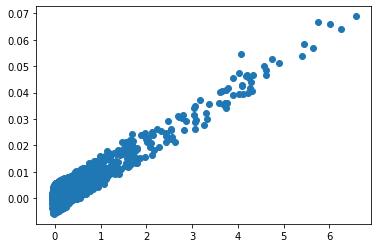

In [83]:
plt.scatter(neww_X[:,0], neww_X[:,1])
vocab = list(model_cbow_Fox.wv.vocab)
for i, word in enumerate(vocab):
  plt.annotate(word, xy=(neww_X[i,0],neww_X[i,1]))

In [167]:
# analogy test
model_cbow_Fox.wv.most_similar(positive=["woman","chef"], negative=["man"],topn=5)

[('boyardee', 0.6337319016456604),
 ('authority', 0.6059855818748474),
 ('reduction', 0.6022852659225464),
 ('magic', 0.601881206035614),
 ('postseason', 0.5983280539512634)]

In [212]:
# pretty print function
def pp(obj):
    print(pd.DataFrame(obj))
    
def analogy(worda, wordb, wordc):
    result = model_cbow_CNN.wv.most_similar(negative=[worda], 
                                positive=[wordb, wordc])
    return result[0][0]

gendered_stuff = ['president', 'biden', 'crypto' ,'boss', 'intelligence', 'government', 'trump']
occupations = [analogy('man', 'woman', gender) for gender in gendered_stuff]
pp(zip(gendered_stuff, occupations))

              0                1
0     president             vice
1         biden  longest-serving
2        crypto          founder
3          boss          succeed
4  intelligence          broadly
5    government          broadly
6         trump          sanders


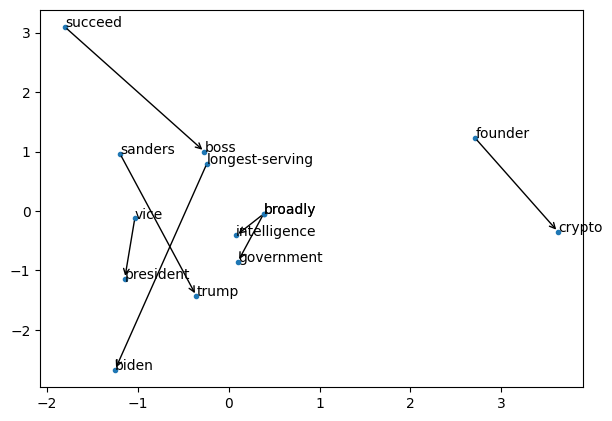

In [213]:
from sklearn.decomposition import PCA

def plot_data(orig_data, labels):
    pca = PCA(n_components=2)
    data = pca.fit_transform(orig_data)
    plt.figure(figsize=(7, 5), dpi=100)
    plt.plot(data[:,0], data[:,1], '.')
    for i in range(len(data)):
        plt.annotate(labels[i], xy = data[i])
    for i in range(len(data)//2):
        plt.annotate("",
                xy=data[i],
                xytext=data[i+len(data)//2],
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3")
        )
       
labels = gendered_stuff + occupations
data = [model_cbow_CNN.wv[w] for w in labels]
plot_data(data, labels)